In [1]:
# Import libraries
import psycopg
import credentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from IPython.display import display, Markdown

In [2]:
# Do not display warnings in the output
warnings.filterwarnings('ignore')

In [3]:
# Set parameter cell to accept "week" from command line
week = '2022-10-21'

In [4]:
# Parameters
week = "2022-10-07"


In [5]:
display(Markdown(f'# Weekly Report of U.S Hospitals for {week}'))

# Weekly Report of U.S Hospitals for 2022-10-07

## Data source: U.S. Health and Human Services (HHS) and Center for Medicare and Medicaid (CMS)
### Created by Team Drummers
### Team Members: Myung Kyung Hyeon, Xi Chen, Sean Tavares

This is a report generated by an automatic reporting system that summarizes the changes in the hospital data in the given week.

In [6]:
# Query for Required Question 1 (Xi)
DATA_LOADED = """SELECT count(hospital_id) AS data_loaded, report_date
                 from averages
                 WHERE report_date <= CAST(%(week)s AS DATE)
                 GROUP BY report_date
                 ORDER BY report_date DESC;"""

In [7]:
# Query for Required Question 2 (Xi)
BEDS_CONDITION = """SELECT report_date,
                 SUM(averages.adult_hospital_beds_avg * 7) AS adult_beds,
                 SUM(averages.pediatric_inpatient_beds_avg * 7) AS pediatric_beds,
                 SUM((averages.adult_occupied_beds_coverage + averages.pediatric_occupied_beds_avg) * 7) AS bed_used,
                 SUM(averages.beds_used_covid_avg * 7) AS covid_beds
                 FROM averages
                 WHERE report_date <= CAST(%(week)s AS DATE)
                 GROUP BY report_date
                 ORDER BY report_date ASC;
                 """

In [8]:
# Query for Required Question 3 (Sean)
SELECT_BY_RATING = """SELECT s.overall_quality_rating, avg(
                      (a.pediatric_occupied_beds_avg * 7 + icu_beds_used_avg * 7) / 
                      (a.pediatric_inpatient_beds_avg * 7 + a.total_icu_beds_avg * 7))
                      FROM Averages as a INNER JOIN Statuses AS s ON a.hospital_id = s.hospital_id
                      WHERE (a.pediatric_inpatient_beds_avg * 7) > 0 AND (a.pediatric_inpatient_beds_avg * 7) IS NOT NULL
                      AND s.overall_quality_rating IS NOT NULL
                      AND s.report_date <= CAST(%(week)s AS DATE)
                      AND a.icu_beds_used_avg > 0
                      AND a.icu_beds_used_avg IS NOT NULL
                      AND a.total_icu_beds_avg > 0
                      AND a.total_icu_beds_avg IS NOT NULL
                      GROUP BY s.overall_quality_rating
                      ORDER BY s.overall_quality_rating DESC;
                      """

In [9]:
# Query for Required Question 4 (Rachel)
SELECT_BEDS = """SELECT report_date,
                 SUM(averages.pediatric_occupied_beds_avg * 7) + SUM(averages.icu_beds_used_avg * 7) AS hosp_beds,
                 SUM(averages.beds_used_covid_avg * 7) AS covid_beds
                 FROM averages
                 WHERE report_date <= CAST(%(week)s AS DATE)
                 GROUP BY report_date
                 ORDER BY report_date ASC;
                 """

In [10]:
# Query for Optional Question 1 (Xi and Sean)
SELECT_COVID = """SELECT SUM(a1.beds_used_covid_avg * 7 - a2.beds_used_covid_avg * 7), h.state
                  FROM Averages AS a1 INNER JOIN (SELECT * FROM Averages
                  WHERE report_date = CAST(%(date)s AS DATE)
                  AND beds_used_Covid_avg IS NOT NULL) As a2
                  ON a1.hospital_id = a2.hospital_id
                  INNER JOIN Hospitals AS h
                  ON h.hospital_id = a1.hospital_id
                  WHERE a1.report_date = CAST(%(week)s AS DATE) AND a1.beds_used_covid_avg IS NOT NULL
                  GROUP BY h.state
                  ORDER BY SUM(a1.beds_used_covid_avg * 7 - a2.beds_used_covid_avg * 7) DESC;"""

In [11]:
# Query for Optional Question 2 (Sean)
COVID_HOSPITALS = """SELECT h.hospital_name, h.address, h.city, h.state,
                     h.zip, h.fips_code, SUM(a1.beds_used_covid_avg * 7 - a2.beds_used_covid_avg * 7)
                     FROM Averages AS a1 INNER JOIN (SELECT * FROM Averages
                     WHERE report_date = CAST(%(date)s AS DATE)
                     AND beds_used_Covid_avg IS NOT NULL) AS a2
                     ON a1.hospital_id = a2.hospital_id
                     INNER JOIN Hospitals AS h
                     ON h.hospital_id = a1.hospital_id
                     WHERE a1.report_date = CAST(%(week)s AS DATE) AND a1.beds_used_covid_avg IS NOT NULL
                     GROUP BY h.hospital_id, h.hospital_name, h.address, h.city, h.state, h.zip, h.fips_code
                     ORDER BY SUM(a1.beds_used_covid_avg * 7 - a2.beds_used_covid_avg * 7) DESC;
                     """

In [12]:
# Query for Optional Question 3 (Sean)
SELECT_MISSING = """
                 SELECT max(a.report_date) as most_recent_report_date, max(h.hospital_name)
                 FROM averages AS a INNER JOIN hospitals AS h ON a.hospital_id = h.hospital_id
                 GROUP BY h.hospital_id
                 HAVING (max(a.report_date) < %(date)s)
                 LIMIT 20;
                 """

In [13]:
# Query for Optional Question 4 (Rachel)
SELECT_LARGEST_COVID = """SELECT h.hospital_name, h.address,
                          h.city, h.state, h.zip, h.fips_code,
                          a.beds_used_covid_avg * 7 as covid_inpatient
                          FROM averages as a
                          INNER JOIN
                          hospitals as h
                          ON a.hospital_id = h.hospital_id
                          WHERE a.report_date = CAST(%(week)s AS DATE)
                          AND a.beds_used_covid_avg IS NOT NULL
                          ORDER BY covid_inpatient DESC
                          LIMIT 15;
                          """

In [14]:
date = datetime.strptime(week, "%Y-%m-%d")
date = date - timedelta(weeks=1)

In [15]:
conn = psycopg.connect(
    host="sculptor.stat.cmu.edu", dbname=credentials.DB_USER,
    user=credentials.DB_USER, password=credentials.DB_PASSWORD
)

cur = conn.cursor()

with conn.transaction():
    # Load data from psql and output Pandas dataframe
    # Required question 1
    table_data = pd.read_sql_query(DATA_LOADED, con=conn, params = {'week':week})
    # Required question 2
    beds_data = pd.read_sql_query(BEDS_CONDITION, con=conn, params = {'week':week})
    # Required question 3
    hospitals_by_quality = pd.read_sql_query(SELECT_BY_RATING, con = conn, params = {'week':week})
    # Required question 4
    beds_used_per_week = pd.read_sql_query(SELECT_BEDS, con=conn, params = {'week':week})
    # Optional question 1
    covid_hosp = pd.read_sql_query(SELECT_COVID, con = conn, params = {'date':date, 'week':week})
    # Optional question 2
    last_covid = pd.read_sql_query(COVID_HOSPITALS, con = conn, params = {'date':date, 'week':week})
    # Optional question 3
    hospitals_not_reporting = pd.read_sql_query(SELECT_MISSING, con = conn, params = {"date":date})
    # Optional question 4
    largest_covid_hospitals = pd.read_sql_query(SELECT_LARGEST_COVID, params={'week':week}, con=conn)
conn.commit()
conn.close()

### 1. A Summary of Hospital Record Changes

Below is a summary of how many hospital records were loaded in the most recent week, and how that compares to previous weeks.

In [16]:
table_data.columns = ["Data Loaded", "Report Date"]
table_data.style.hide_index()

Data Loaded,Report Date
4996,2022-10-07
4997,2022-09-30
4995,2022-09-23


### 2. Summary of Hospital Beds Available and Used over 5 Most Recent Weeks

Below is a table summarizing the number of adult and pediatric beds available this week, the number used, and the number used by patients with COVID, compared to the 4 most recent weeks.

In [17]:
beds_data['report_date'] = pd.to_datetime(beds_data['report_date'])
beds_data_sorted = beds_data.sort_values(by='report_date')
beds_data_sorted.columns = ["Report Date", "Adult Beds", "Pediatric Beds", "Bed Used", "COVID Beds"]
beds_data_sorted.head(5).style.hide_index().format({'Report Date': '{:%Y-%m-%d}'}, precision=0)

Report Date,Adult Beds,Pediatric Beds,Bed Used,COVID Beds
2022-09-23,2894916,277238,407170,179204
2022-09-30,2913956,278633,410073,168998
2022-10-07,2908258,278578,411620,165825


### 3. Fraction of Beds in Use by Quality Rating
Below is a graph or table summarizing the fraction of beds currently in use by hospital quality rating, so we can compare high-quality and low-quality hospitals

In [18]:
hospitals_by_quality.columns = ["Overall Quality Rating", "Average Fraction of Beds in Use"]
hospitals_by_quality.style.format(precision = 3).hide_index()

Overall Quality Rating,Average Fraction of Beds in Use
5,0.693
4,0.724
3,0.699
2,0.715
1,0.692


### 4. Total Beds Occupied per Week

Below is a bar plot showing the total number of hospital beds used per week, over all time, split into all cases and COVID cases.

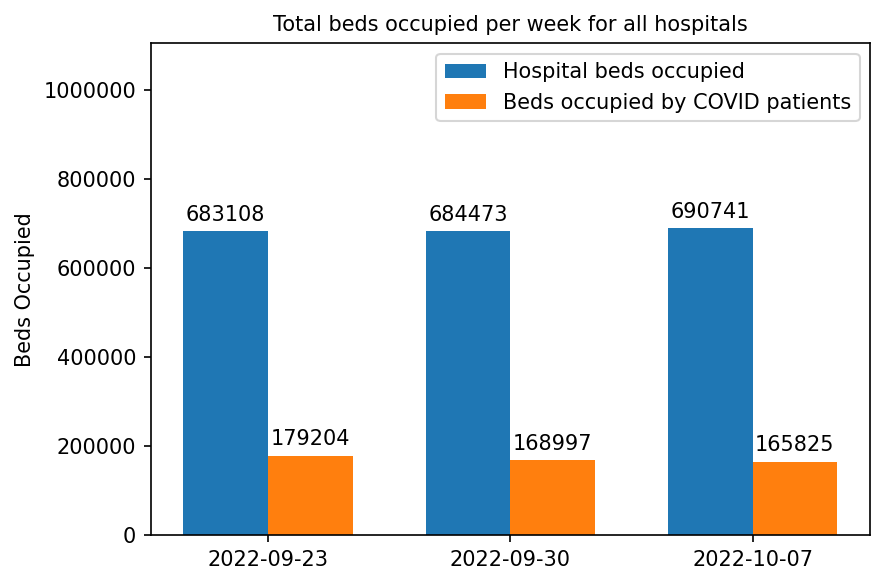

In [19]:
ymax = beds_used_per_week["hosp_beds"].max()

x = np.arange(len(beds_used_per_week["report_date"]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=150)
rects1 = ax.bar(x - width/2, beds_used_per_week["hosp_beds"], width, label='Hospital beds occupied')
rects2 = ax.bar(x + width/2, beds_used_per_week["covid_beds"], width, label='Beds occupied by COVID patients')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Beds Occupied')
ax.set_title('Total beds occupied per week for all hospitals', fontdict={'fontsize' : 10})
ax.set_xticks(x, beds_used_per_week["report_date"])
# ax.legend(bbox_to_anchor=(1, 1.1))
ax.legend()
# Make space between title and maximum bar plot
ymax = ymax*1.6
ax.set_ylim([None, ymax])

ax.bar_label(rects1, padding=3, fmt = '%d')
ax.bar_label(rects2, padding=3, fmt = '%d')

fig.tight_layout()

plt.rcParams['figure.figsize'] = [8, 8]

plt.show()

### 5. States with the Largest Increase in Number of COVID Cases from Last Week
Below is a table of the states in which the number of cases has increased by the most since last week.

In [20]:
covid_hosp.columns = ["Increase in Covid Cases", "State"]
covid_hosp.head().style.format(precision=0).hide_index()

Increase in Covid Cases,State
1296,NY
750,NJ
458,PA
443,MA
91,CO


### 6. Hospitals with Largest Changes in COVID Cases
Below is a table of the hospitals (including names and locations) with the largest changes in COVID cases in the last week.

In [21]:
last_covid.columns = ["Hospital Name", "Address", "City", "State", "Zip", "FIPS Code", "Changes in COVID Cases"]
last_covid.head().style.format(precision=0).hide_index()

Hospital Name,Address,City,State,Zip,FIPS Code,Changes in COVID Cases
LONG ISLAND JEWISH MEDICAL CENTER,270 - 05 76TH AVENUE,NEW HYDE PARK,NY,11040,36081,169
READING HOSPITAL,420 S 5TH AVENUE,WEST READING,PA,19611,42011,150
HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,1089,135
ATRIUM HEALTH LINCOLN,433 MCALISTER RD,LINCOLNTON,NC,28092,37109,108
KALEIDA HEALTH,100 HIGH STREET,BUFFALO,NY,14210,36029,107


### 7. Hospitals that Did Not Report Data in the Last Week
Below is a table of hospitals that did not report any data in the past week, their names, and the date they most recently reported data.

In [22]:
hospitals_not_reporting.columns = ["Most Recent Report Date", "Hospital Name"]
hospitals_not_reporting = hospitals_not_reporting.iloc[:,[1,0]]
hospitals_not_reporting.style.format(precision = 3).hide_index()

Hospital Name,Most Recent Report Date
BLESSING HEALTH KEOKUK,2022-09-23


### 8. Top 15 Hospitals with the Highest Number of COVID Inpatients

Below is a table showing the top 15 hospitals with the highest number of COVID inpatients for the requested report week. Hospital name and address are shown below.

In [23]:
def make_pretty(styler):
    styler.set_caption("Top 15 Hospitals with Highest Number of COVID Inpatient")
    styler.background_gradient(axis=None, cmap="YlGnBu")
    return styler

In [24]:
largest_covid_hospitals.columns = ["Hospital Name", "Address", "City", "State", "ZIP", "FIPS Code", "COVID Inpatient"]
largest_covid_hospitals.style.format(precision=0).pipe(make_pretty).hide_index()

Hospital Name,Address,City,State,ZIP,FIPS Code,COVID Inpatient
CAROLINAS MEDICAL CENTER/BEHAV HEALTH,1000 BLYTHE BLVD,CHARLOTTE,NC,28203,37119,1858
LONG ISLAND JEWISH MEDICAL CENTER,270 - 05 76TH AVENUE,NEW HYDE PARK,NY,11040,36081,1243
NEW YORK-PRESBYTERIAN HOSPITAL,525 EAST 68TH STREET,NEW YORK,NY,10065,36061,1201
READING HOSPITAL,420 S 5TH AVENUE,WEST READING,PA,19611,42011,1172
ATRIUM HEALTH CABARRUS,920 CHURCH ST N,CONCORD,NC,28025,37025,1037
ATRIUM HEALTH PINEVILLE,10628 PARK RD,CHARLOTTE,NC,28210,37119,841
WELLSTAR KENNESTONE REGIONAL MEDICAL CENTER,677 CHURCH STREET,MARIETTA,GA,30060,13067,837
ADVENTHEALTH ORLANDO,601 E ROLLINS ST,ORLANDO,FL,32803,12095,799
HOUSTON METHODIST HOSPITAL,6565 FANNIN,HOUSTON,TX,77030,48201,728
NORTON HOSPITAL / NORTON HEALTHCARE PAVILION / NOR,200 EAST CHESTNUT STREET,LOUISVILLE,KY,40202,21111,684
